In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
from skimage.color import rgb2gray

import cv2
import heapq
from collections import defaultdict, Counter

import torch
import torchvision.transforms as transforms
from PIL import Image
from compressai.zoo import models
from datetime import datetime

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Load images from Oxford Pets dataset directory
dataset_dir = "data/images"  # Update this with the correct path
image_files = os.listdir(dataset_dir)
# Select the first 5 images (assuming they are in .jpg or .png format)
sample_images = []
sample_images_gray = []
for i, file in enumerate(image_files[:5]):
    if file.endswith(('.jpg', '.png')):
        image_path = os.path.join(dataset_dir, file)
        image = io.imread(image_path)
        image_grey = rgb2gray(image)  # Convert to grayscale for simplicity
        sample_images.append(image)
        sample_images_gray.append(image_grey)

# SVD image compression

Singular Value Decomposition (SVD) is a very powerful and useful technique used for data dimensionality reduction and image compression. In this context, it reduces the storage requirements by approximating an image while preserving its most prominent visual features.

Here's a step-by-step explanation of how SVD image compression works:
1. We first represent the grayscale image as a 2D matrix $A$, where each element is representative of a pixel's intensity at the specific position.

2. We then decompose the matrix $A$ into three matrices: $A = USV^T$. $U$ is an orthogonal matrix representing the left singular vectors, $S$ is a diagonal matrix containing the singular values (which can be thought of as the important feature weights), and $V^T$ is an orthogonal matrix representing the right singular vectors.

3. We would then select some value $k$ to represent the number of singular values to retain. We note the trucated image representation retaining the $k$ top singular values as $A_k$. This means our new representation is $A_k = U_kS_kV_k^T$. Our goal is to make it so that $A_k$ (which would include the sizes of $U_k$, $S_k$, and $V_k$) is less in size than the original image file $A$.

**An Aside:** Let's take a look at the image compression we do below. The original image has size $n \times n = 1024$ which means the size of the image is $32 \times 32$. However, when we compress images, we are actually saving $U_k, \Sigma_k, V_k^T$ where $U_k$ is $n \times k$, $\Sigma_k$ is $k \times k$, and $V_k^T$ is $k \times n$. Therefore, we are storing $(n \times k) + (k \times k) + (k \times n) = 2nk + k^2$. In order to truly compress the images ot get smaller than $1024$ elements, we will need $2nk + k^2 = 64k + k^2 = k(k + 64) < 1024$. The solution to this is $k < \approx 13.26$ so we will need to compress with saving only $13$ singular values or less.

**Explanation of the Code**: In the provided code below, the CIFAR-10 dataset is used to demonstrate SVD compressions. We first have an inout of the grayscale images that are being processed using SVD. Then for each image, we choose different $k$ values to determine the number of singular values to retain and then sicualize the original images with their compressed counterparts and then print the sizes for comparison.

Compression with k = 5
Image 1:
  Original size: 187500 elements
  Compressed size: 4400 elements
  Compression ratio: 42.61x
Image 2:
  Original size: 197000 elements
  Compressed size: 4495 elements
  Compression ratio: 43.83x
Image 3:
  Original size: 166500 elements
  Compressed size: 4190 elements
  Compression ratio: 39.74x
Image 4:
  Original size: 270050 elements
  Compressed size: 5230 elements
  Compression ratio: 51.63x
Image 5:
  Original size: 200500 elements
  Compressed size: 4530 elements
  Compression ratio: 44.26x


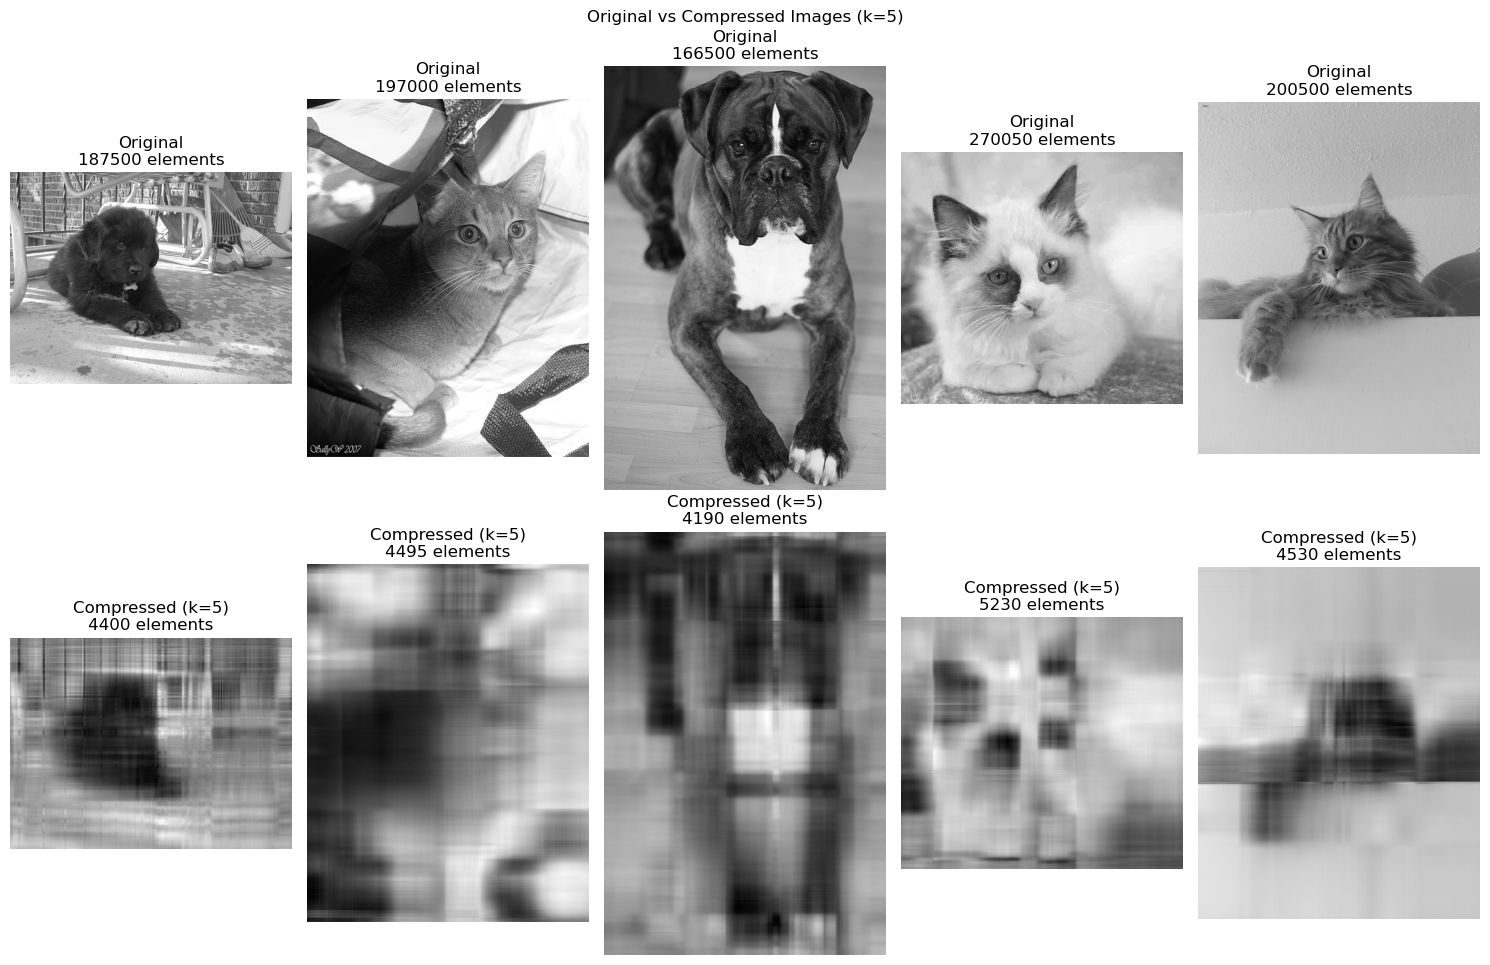

Compression with k = 10
Image 1:
  Original size: 187500 elements
  Compressed size: 8850 elements
  Compression ratio: 21.19x
Image 2:
  Original size: 197000 elements
  Compressed size: 9040 elements
  Compression ratio: 21.79x
Image 3:
  Original size: 166500 elements
  Compressed size: 8430 elements
  Compression ratio: 19.75x
Image 4:
  Original size: 270050 elements
  Compressed size: 10510 elements
  Compression ratio: 25.69x
Image 5:
  Original size: 200500 elements
  Compressed size: 9110 elements
  Compression ratio: 22.01x


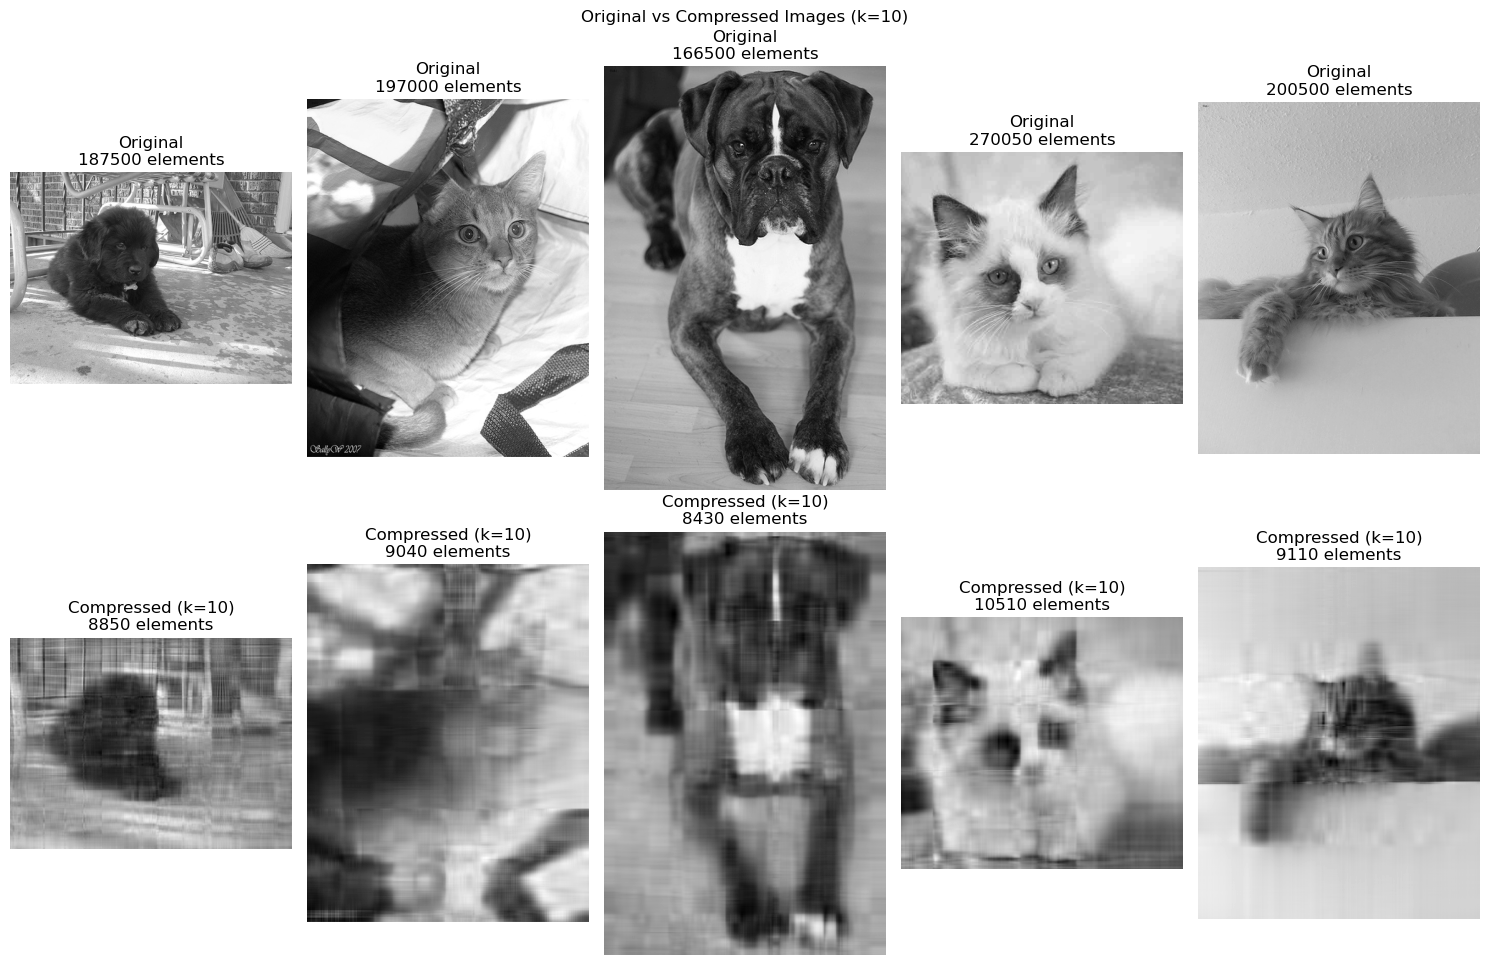

Compression with k = 20
Image 1:
  Original size: 187500 elements
  Compressed size: 17900 elements
  Compression ratio: 10.47x
Image 2:
  Original size: 197000 elements
  Compressed size: 18280 elements
  Compression ratio: 10.78x
Image 3:
  Original size: 166500 elements
  Compressed size: 17060 elements
  Compression ratio: 9.76x
Image 4:
  Original size: 270050 elements
  Compressed size: 21220 elements
  Compression ratio: 12.73x
Image 5:
  Original size: 200500 elements
  Compressed size: 18420 elements
  Compression ratio: 10.88x


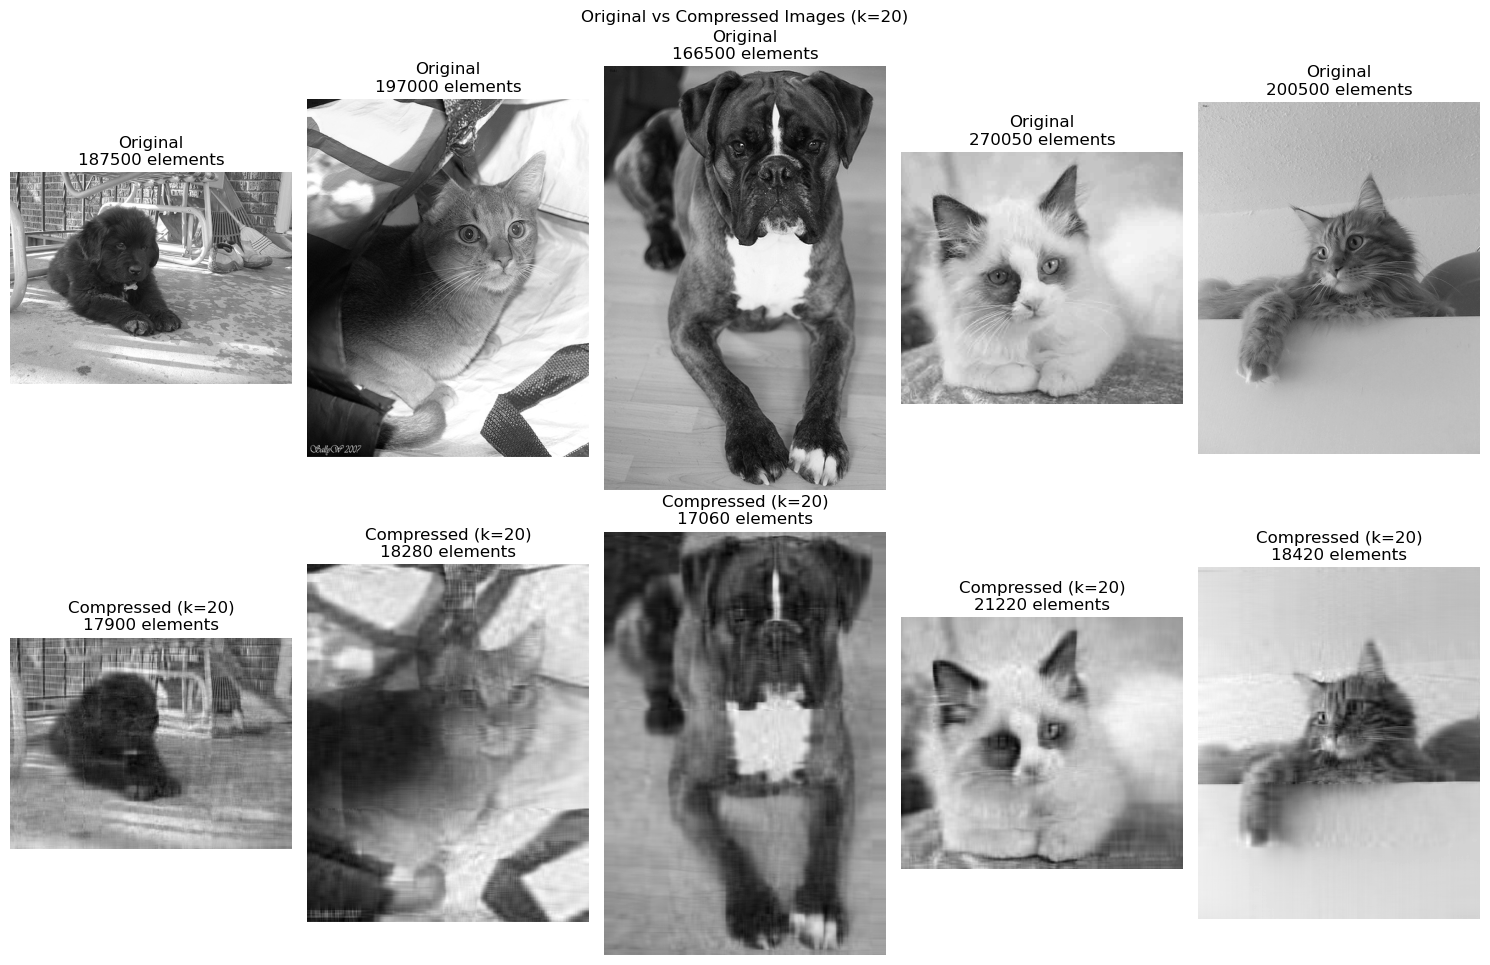

Compression with k = 40
Image 1:
  Original size: 187500 elements
  Compressed size: 36600 elements
  Compression ratio: 5.12x
Image 2:
  Original size: 197000 elements
  Compressed size: 37360 elements
  Compression ratio: 5.27x
Image 3:
  Original size: 166500 elements
  Compressed size: 34920 elements
  Compression ratio: 4.77x
Image 4:
  Original size: 270050 elements
  Compressed size: 43240 elements
  Compression ratio: 6.25x
Image 5:
  Original size: 200500 elements
  Compressed size: 37640 elements
  Compression ratio: 5.33x


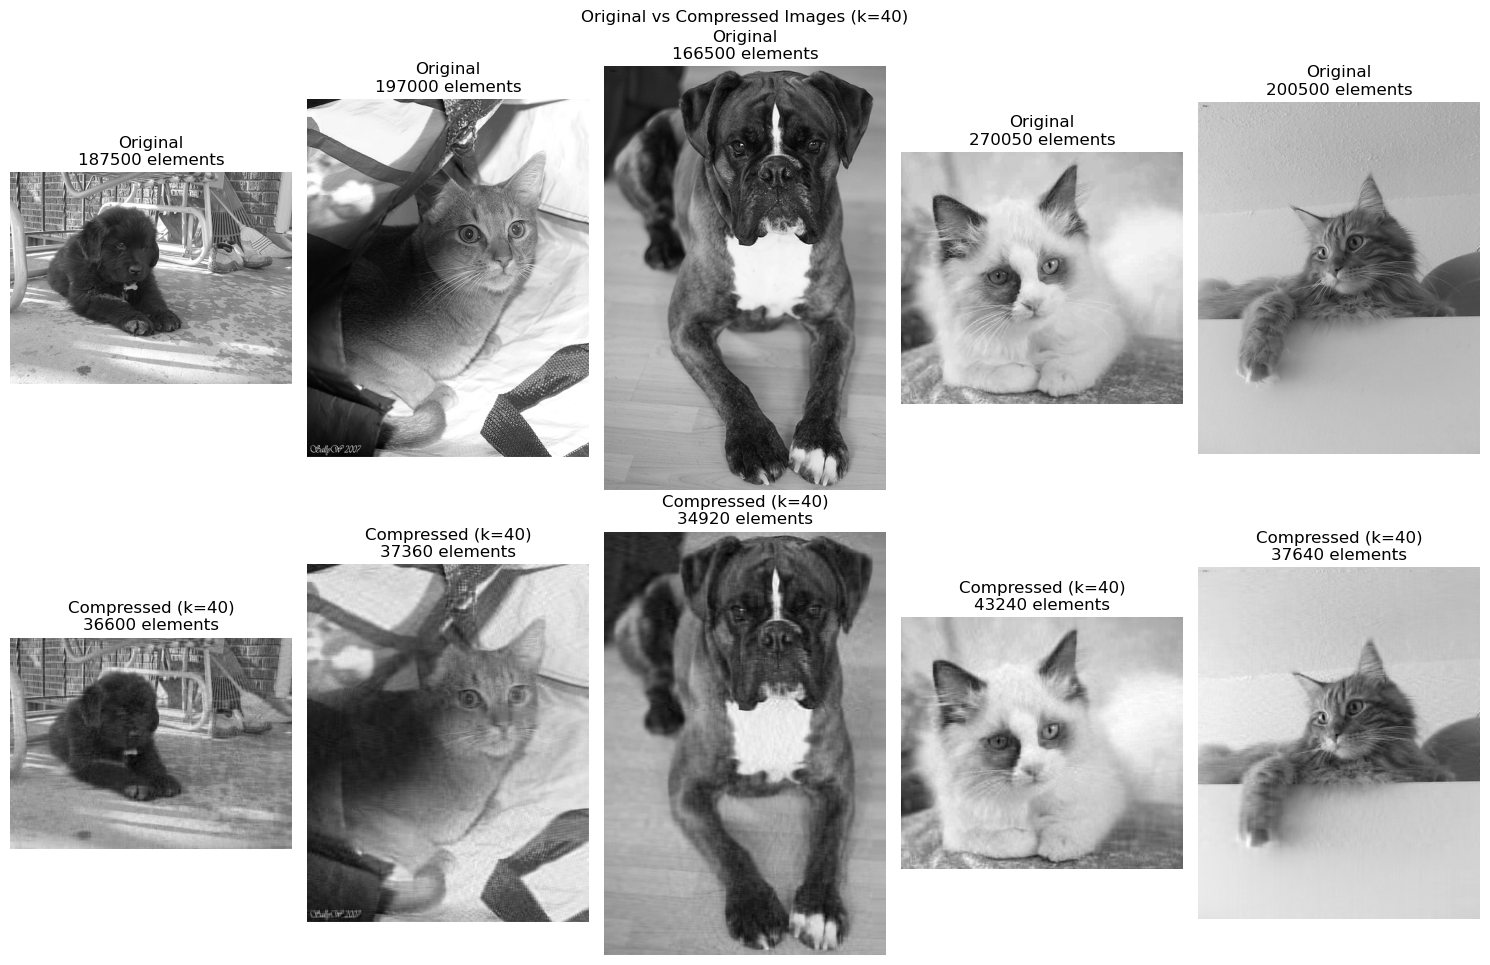

In [5]:
def svd_compress(image, k):
    U, S, VT = np.linalg.svd(image, full_matrices=False)
    S = np.diag(S)
    U_k = U[:, :k]
    S_k = S[:k, :k]
    VT_k = VT[:k, :]
    compressed_image = np.dot(U_k, np.dot(S_k, VT_k))
    return U_k, S_k, VT_k, compressed_image

# Adjusted k-values for the image size
k_values = [5, 10, 20, 40]
# Display original and compressed images
for k in k_values:
    print(f"Compression with k = {k}")
    plt.figure(figsize=(15, 10))
    
    for i, image in enumerate(sample_images_gray):
        original_size = image.size
        plt.subplot(2, len(sample_images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original\n{original_size} elements")
        plt.axis('off')
        
        U_k, S_k, VT_k, compressed_image = svd_compress(image, k)
        compressed_size = U_k.size + S_k.size + VT_k.size
        
        plt.subplot(2, len(sample_images), i + 1 + len(sample_images))
        plt.imshow(compressed_image, cmap='gray')
        plt.title(f"Compressed (k={k})\n{compressed_size} elements")
        plt.axis('off')
        
        print(f"Image {i + 1}:")
        print(f"  Original size: {original_size} elements")
        print(f"  Compressed size: {compressed_size} elements")
        print(f"  Compression ratio: {original_size/compressed_size:.2f}x")
    
    plt.suptitle(f"Original vs Compressed Images (k={k})")
    plt.tight_layout()
    plt.show()

# Huffman Coding

Huffman coding is a popular algorithm used for lossless data compression. The basic idea is to assign variable-length codes to input characters, with shorter codes assigned to more frequent characters. This way, the overall length of the encoded data is minimized.

Here's a step-by-step explanation of how Huffman coding works:

1. Frequency Calculation: Calculate the frequency of each character in the input data.

2. Priority Queue: Create a priority queue (or a min-heap) and insert all characters with their frequencies. Each character is treated as a leaf node of a tree.

3. Tree Construction:

    - While there is more than one node in the queue:
        - Remove the two nodes with the lowest frequency from the queue.
        - Create a new internal node with these two nodes as children and with a frequency equal to the sum of their frequencies.
        - Insert the new node back into the queue.
    - The remaining node is the root of the Huffman tree.
4. Code Assignment: Traverse the Huffman tree and assign codes to characters:

    - Assign '0' for the left edge and '1' for the right edge.
    - The code for each character is the sequence of edges from the root to the leaf node representing that character.
5. Encoding: Replace each character in the input data with its corresponding Huffman code.

6. Decoding: Use the Huffman tree to decode the encoded data by traversing the tree according to the sequence of bits.



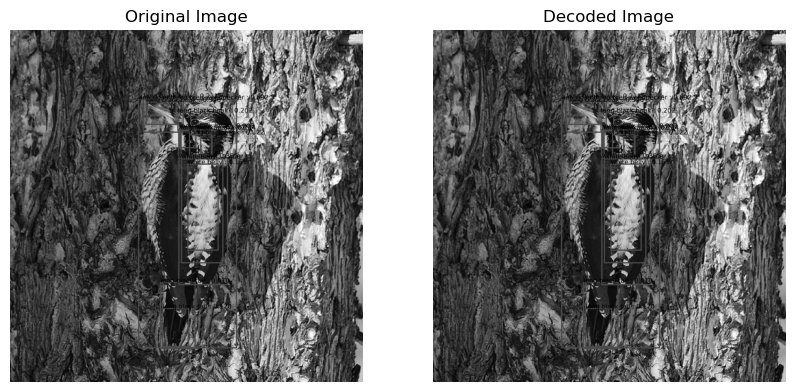

In [6]:
# Define the Node class for the Huffman tree
class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

# Function to build the Huffman tree
def build_huffman_tree(frequency):
    heap = [Node(char, freq) for char, freq in frequency.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)

    return heap[0]

# Function to build the Huffman codes
def build_codes(node, prefix="", codebook={}):
    if node is not None:
        if node.char is not None:
            codebook[node.char] = prefix
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

# Function to encode the image using Huffman coding
def huffman_encoding(image):
    # Normalize and quantize to integers if image is in 0-1 range
    if image.dtype == np.float64 or image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)
    
    flat_image = image.flatten()
    frequency = Counter(flat_image)
    root = build_huffman_tree(frequency)
    codebook = build_codes(root)
    encoded_image = ''.join(codebook[pixel] for pixel in flat_image)
    return encoded_image, root, image.shape

# Function to decode the Huffman encoded image
def huffman_decoding(encoded_image, root, shape):
    decoded_image = []
    node = root
    for bit in encoded_image:
        node = node.left if bit == '0' else node.right
        if node.char is not None:
            decoded_image.append(node.char)
            node = root
    decoded_image = np.array(decoded_image, dtype=np.uint8).reshape(shape)
    return decoded_image


# Example usage
image_path = '0.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale

encoded_image, tree, shape = huffman_encoding(image)
decoded_image = huffman_decoding(encoded_image, tree, shape)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Decoded Image")
plt.imshow(decoded_image, cmap='gray')
plt.axis('off')

plt.show()

In [35]:
# "Size of original image (in bytes):", image.nbytes

In [36]:
# "Size of encoded image (in bytes):", len(encoded_image) // 8
# len(encoded_image)

In [37]:
# "Compression factor : {}".format(image.nbytes / (len(encoded_image)//8))

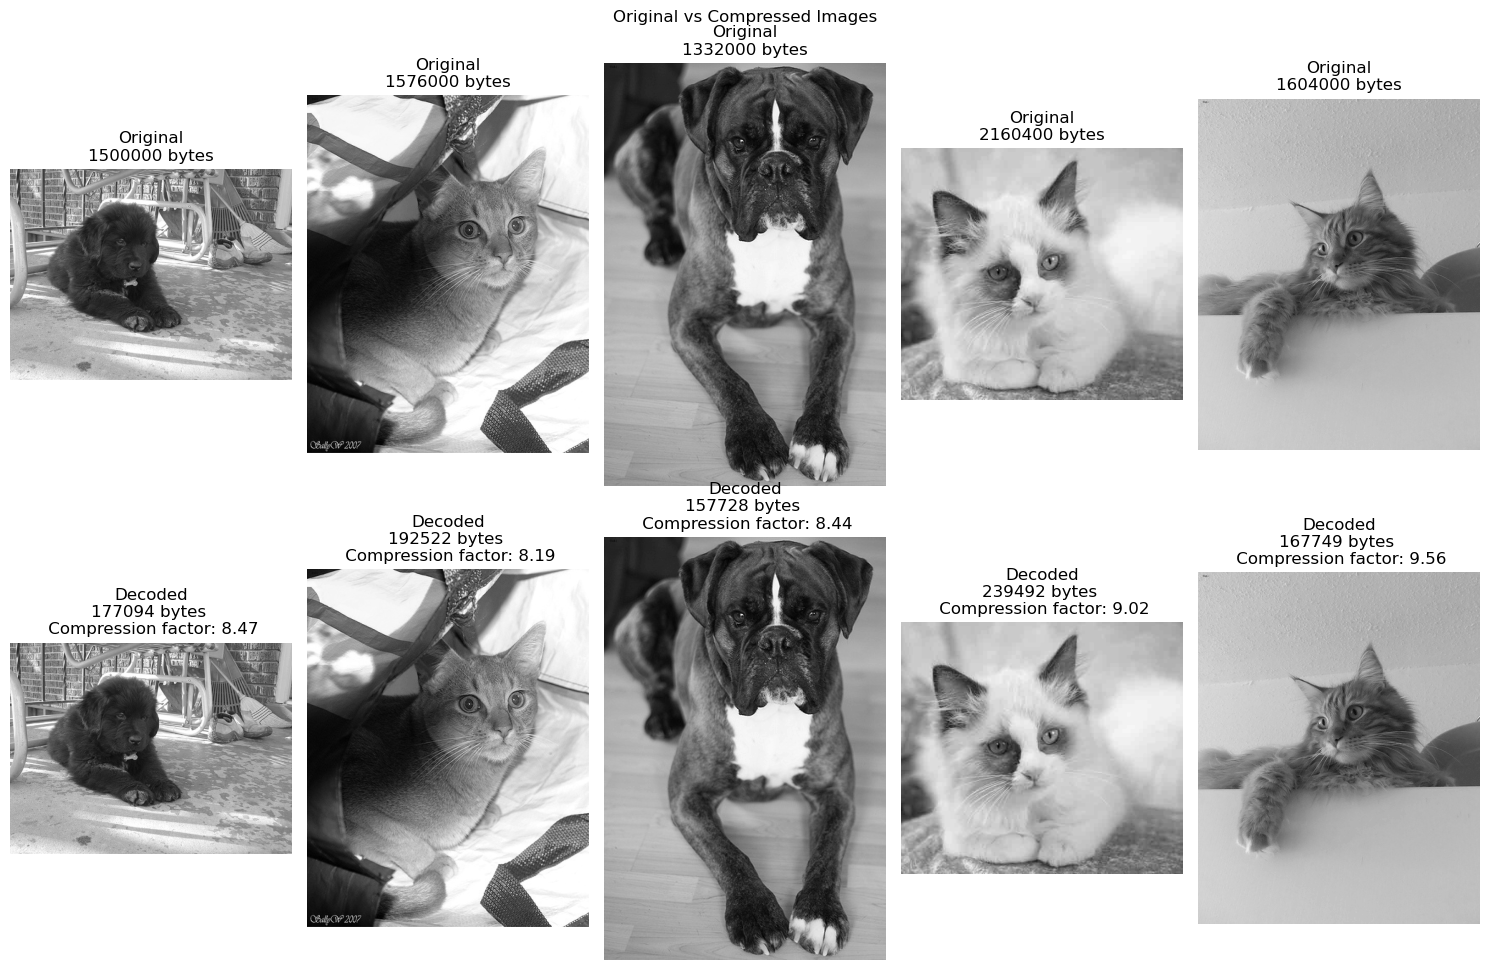

In [7]:
plt.figure(figsize=(15, 10))
for i, img in enumerate(sample_images_gray):
    encoded_image, tree, shape = huffman_encoding(img)
    decoded_image = huffman_decoding(encoded_image, tree, shape)
    compression_factor = img.nbytes / (len(encoded_image)//8)

    plt.subplot(2, len(sample_images_gray), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{img.nbytes} bytes")
    plt.axis('off')

    plt.subplot(2, len(sample_images), i + 1 + len(sample_images_gray))
    plt.imshow(decoded_image, cmap='gray')
    plt.title(f"Decoded\n{len(encoded_image) // 8} bytes \n Compression factor: {compression_factor:.2f}")
    plt.axis('off')

plt.suptitle(f"Original vs Compressed Images")
plt.tight_layout()
plt.show()

# Learned Image Compression (LIC)


In [8]:
def compress_image_with_pretrained(img, quality=1, output_prefix=""):
    """
    Compress an image using a pre-trained CompressAI model
    """
    # img = Image.open(image_path).convert('RGB')
    
    # Load model
    model = models['bmshj2018-factorized'](quality=quality, pretrained=True)
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Transform and pad
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    _, _, h, w = x.shape
    pad_h = (64 - (h % 64)) % 64
    pad_w = (64 - (w % 64)) % 64
    
    if pad_h > 0 or pad_w > 0:
        x = torch.nn.functional.pad(x, (0, pad_w, 0, pad_h))
    
    # Compress and decompress
    with torch.no_grad():
        compressed = model.compress(x)
        decompressed = model.decompress(compressed['strings'], compressed['shape'])
    
    # Post-process
    x_hat = decompressed['x_hat']
    if pad_h > 0 or pad_w > 0:
        x_hat = x_hat[:, :, :h, :w]
    
    # Convert to PIL Image
    out_img = transforms.ToPILImage()(x_hat.squeeze().cpu().clamp_(0, 1))
    
    # Calculate stats
    original_size = img.size
    # os.path.getsize(image_path)
    compressed_size = sum(len(s[0]) for s in compressed['strings'])
    
    # Save the output
    output_filename = f"{output_prefix}_q{quality}.png"
    out_img.save(output_filename)
    
    return {
        'quality': quality,
        'original_size_bytes': original_size,
        'compressed_size_bytes': compressed_size,
        'compression_ratio': original_size / compressed_size,
        'output_file': output_filename
    }

def compare_quality_levels(img, qualities=[1, 4, 6, 8]):
    """
    Compare different quality levels of compression
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_prefix = f"compressed_{timestamp}"
    
    results = []
    print("\nProcessing different quality levels:")
    print("-" * 60)
    print(f"{'Quality':<8} {'Original':<12} {'Compressed':<12} {'Ratio':<8}")
    print("-" * 60)
    
    for quality in qualities:
        result = compress_image_with_pretrained(
            img, 
            quality=quality,
            output_prefix=output_prefix
        )
        results.append(result)
        
        print(f"{quality:<8} "
              f"{result['original_size_bytes']/1024:>8.2f} KB "
              f"{result['compressed_size_bytes']/1024:>8.2f} KB "
              f"{result['compression_ratio']:>8.2f}x")
    
    print("-" * 60)
    print(f"\nOutput files saved with prefix: {output_prefix}")
    return results

# results = compare_quality_levels('0.png')


Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------


Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-4-1ed4405a.pth.tar" to /tmp/xdg-cache/torch/hub/checkpoints/bmshj2018-factorized-prior-4-1ed4405a.pth.tar


1          549.32 KB     3.53 KB   155.56x


100%|██████████| 11.6M/11.6M [00:00<00:00, 80.9MB/s]
Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-6-9b02ea3a.pth.tar" to /tmp/xdg-cache/torch/hub/checkpoints/bmshj2018-factorized-prior-6-9b02ea3a.pth.tar


4          549.32 KB    13.00 KB    42.24x


100%|██████████| 27.3M/27.3M [00:01<00:00, 15.4MB/s]
Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-factorized-prior-8-5232faa3.pth.tar" to /tmp/xdg-cache/torch/hub/checkpoints/bmshj2018-factorized-prior-8-5232faa3.pth.tar


6          549.32 KB    31.62 KB    17.37x


100%|██████████| 27.9M/27.9M [00:00<00:00, 71.7MB/s]


8          549.32 KB    63.57 KB     8.64x
------------------------------------------------------------

Output files saved with prefix: compressed_20241205_011753

Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1          577.15 KB     3.20 KB   180.40x
4          577.15 KB    10.79 KB    53.51x
6          577.15 KB    25.27 KB    22.84x
8          577.15 KB    50.75 KB    11.37x
------------------------------------------------------------

Output files saved with prefix: compressed_20241205_011801

Processing different quality levels:
------------------------------------------------------------
Quality  Original     Compressed   Ratio   
------------------------------------------------------------
1          487.79 KB     2.46 KB   198.53x
4          487.79 KB     7.49 KB    65.14x
6          487.79 KB    16.54 KB    29.50x
8     

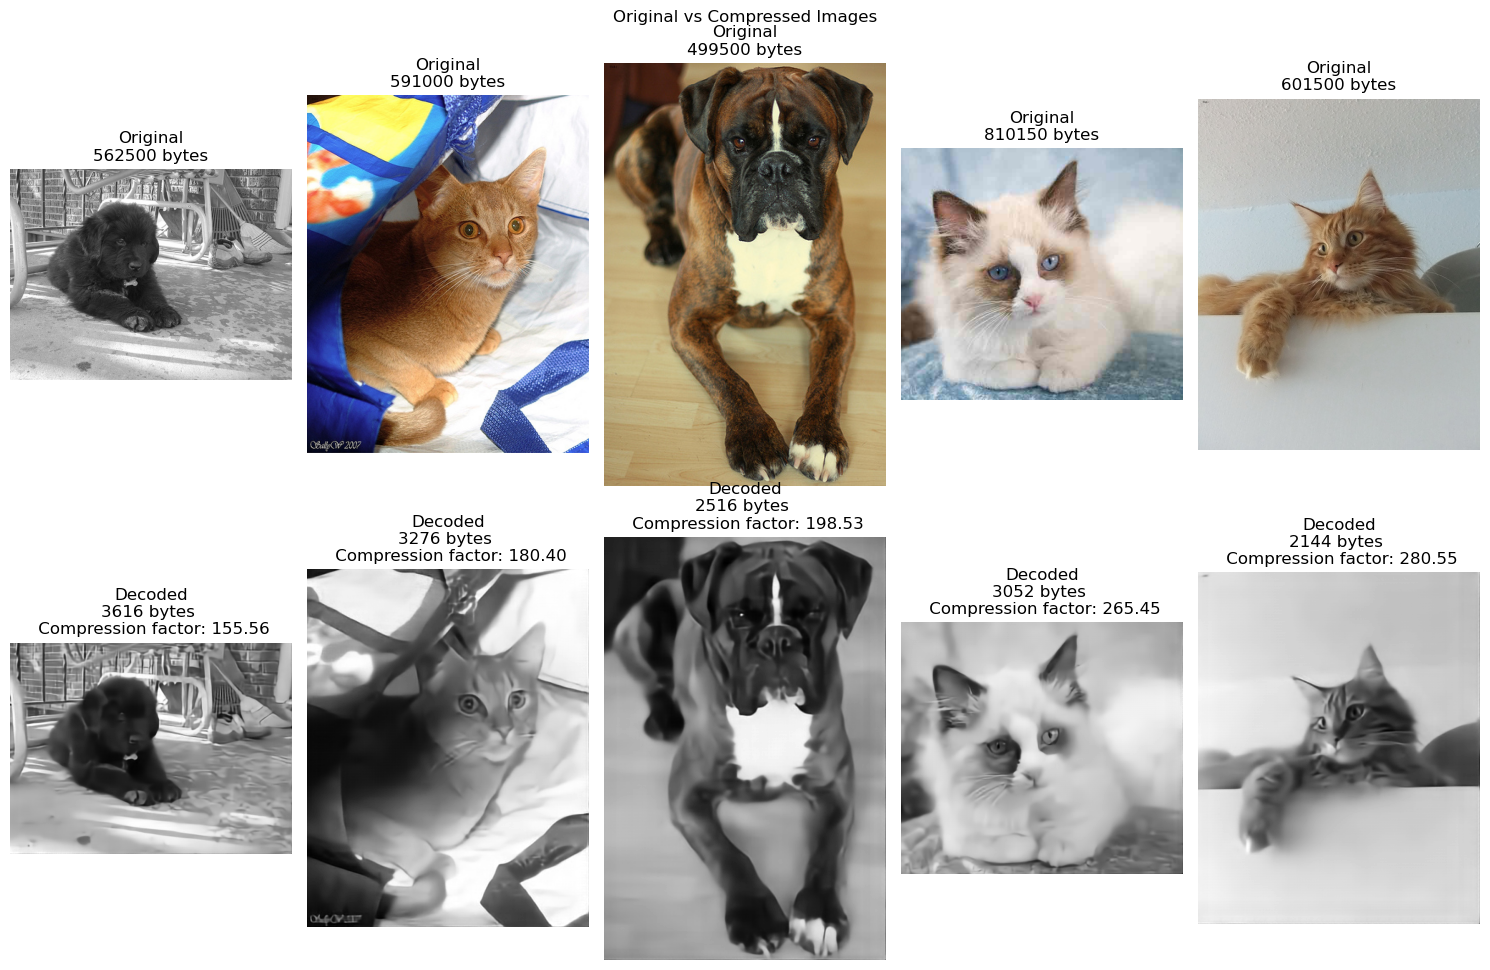

In [9]:
plt.figure(figsize=(15, 10))

for i, img in enumerate(sample_images):
    # encoded_image, tree, shape = huffman_encoding(img)
    # decoded_image = huffman_decoding(encoded_image, tree, shape)
    # compression_factor = img.nbytes / (len(encoded_image)//8)
    results = compare_quality_levels(img)

    # 'quality': quality,
    #     'original_size_bytes': original_size,
    #     'compressed_size_bytes': compressed_size,
    #     'compression_ratio': original_size / compressed_size,
    #     'output_file': output_filename
    decoded_image = Image.open(results[0]['output_file']).convert('L')
    
    plt.subplot(2, len(sample_images), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original\n{results[0]['original_size_bytes']} bytes")
    plt.axis('off')

    plt.subplot(2, len(sample_images), i + 1 + len(sample_images))
    plt.imshow(decoded_image, cmap='gray')
    plt.title(f"Decoded\n{results[0]['compressed_size_bytes']} bytes \n Compression factor: {results[0]['compression_ratio']:.2f}")
    plt.axis('off')

plt.suptitle(f"Original vs Compressed Images")
plt.tight_layout()
plt.show()